# Lab Assignment 6

## Andrew Marquardt

Question 1

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tclab import TCLab, clock, Historian, Plotter

In [94]:
with TCLab() as lab:
    print(lab.T1)
    print(lab.T2)

TCLab version 0.4.9
Arduino Leonardo connected on port COM4 at 115200 baud.
TCLab Firmware 3.0.0 Arduino Leonardo/Micro.
23.863
25.668
TCLab disconnected successfully.


In [50]:
CpH = 8.570225192333513 #Joules/degree C
CpS = 1.1198465579234749 #Joules/degree C
Ua = 0.03916910667788763 #Watts/degree C
Ub = 0.08256218948251515 #Watts/degree C
Uc = 0.03558351485126857 #Watts/degree C
alpha = 0.00016
P1 = 200
P2 = 100
Tamb = 23.8

# state space model
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], 
              [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
              [0, 0, Ub/CpS, -Ub/CpS]])

Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])

Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

# initial values for states and inputs
u_initial = np.array([0, 0])
d_initial = np.array([Tamb])
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])

In [29]:
def tclab_observer(L, x_initial, d_hat):
    
    # initialize
    t = 0
    x_hat = x_initial
    y_err = None

    while True:
        # save previous time value
        t_prev = t
        
        # yield current state and measurement error.
        # wait for message with next time, last control input, and measurement
        t, u, y = yield x_hat, y_err
        
        # update model prediction
        x_pred = x_hat + (t - t_prev)*(np.dot(A, x_hat) + np.dot(Bu, u) + np.dot(Bd, d_hat))
        y_pred = np.dot(C, x_pred)
        
        # measurement correction
        y_err = y_pred - y
        x_hat = x_pred - (t - t_prev)*np.dot(L, y_err)

In [30]:
def experiment(observer, u1, u2, t_final=400, t_step=2, connected=True):
    
    if not connected:
        TCLab = setup(connected=False, speedup=20)
        
    with TCLab() as lab:
        
        # setup historian
        sources = [('T1', lambda: y[0]), 
                   ('T2', lambda: y[1]), 
                   ('Q1', lambda: u[0]), 
                   ('Q2', lambda: u[1]),
                   ('Th1', lambda: x[0]), 
                   ('Ts1', lambda: x[1]), 
                   ('Th2', lambda: x[2]), 
                   ('Ts2', lambda: x[3]),
                   ('y_err_1', lambda: y_err[0]),
                   ('y_err_2', lambda: y_err[1]),
        ]
        h = Historian(sources)
        
        layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['Q1', 'Q2']]
        p = Plotter(h, t_final, layout)
            
        # initialize event loop
        next(observer)
        u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

        for t in clock(t_final, t_step):
            # get new measurement
            y = [lab.T1, lab.T2]
            x, y_err = observer.send([t, u, y])

            # update plotter and historian
            p.update(t)

            # set input for next period
            u = [lab.Q1(u1(t)), lab.Q2(u2(t))]
            
    return h

In [31]:
from scipy.signal import place_poles

evals, _ = np.linalg.eig(A)

results1 = place_poles(A.T, C.T, evals)
L1 = results1.gain_matrix.T

results2 = place_poles(A.T, C.T, evals*2)
L2 = results2.gain_matrix.T

results5 = place_poles(A.T, C.T, evals*5)
L5 = results5.gain_matrix.T

results10 = place_poles(A.T, C.T, evals*10)
L10 = results10.gain_matrix.T

In [35]:
def u1(t):
    return 50 if 20 <= t <= 220 else 0

def u2(t):
    return 60 if 120 <= t <= 320 else 0

t_final = 400
t_step = 2

Experimental Runs

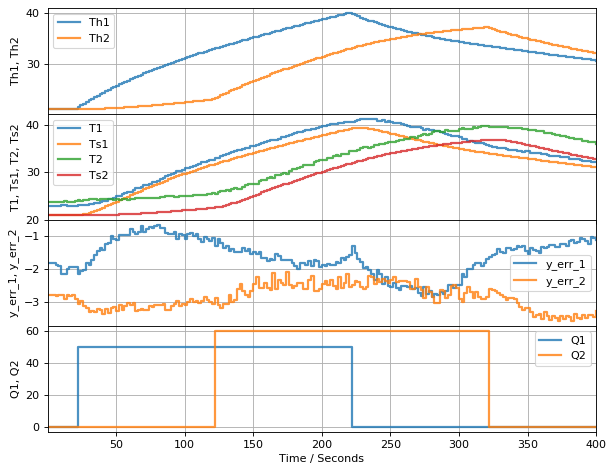

TCLab disconnected successfully.


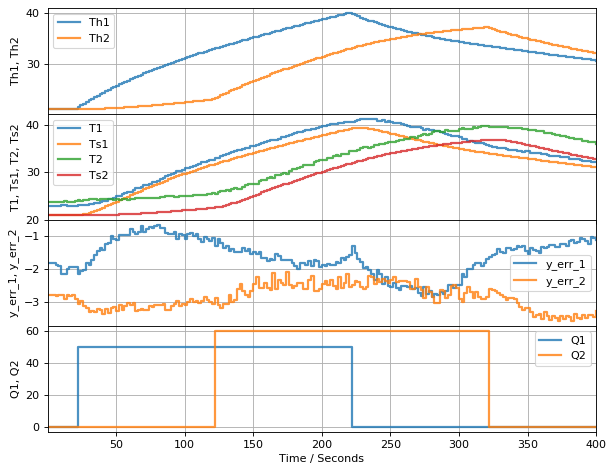

In [36]:
# placed multiple 1
observer = tclab_observer(L1, x_initial, d_initial)
with TCLab() as lab:

    # setup historian
    sources = [('T1', lambda: y[0]), 
               ('T2', lambda: y[1]), 
               ('Q1', lambda: u[0]), 
               ('Q2', lambda: u[1]),
               ('Th1', lambda: x[0]), 
               ('Ts1', lambda: x[1]), 
               ('Th2', lambda: x[2]), 
               ('Ts2', lambda: x[3]),
               ('y_err_1', lambda: y_err[0]),
               ('y_err_2', lambda: y_err[1]),
    ]
    h = Historian(sources)

    layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['Q1', 'Q2']]
    p = Plotter(h, t_final, layout)

    # initialize event loop
    next(observer)
    u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

    for t in clock(t_final, t_step):
        # get new measurement
        y = [lab.T1, lab.T2]
        x, y_err = observer.send([t, u, y])

        # update plotter and historian
        p.update(t)

        # set input for next period
        u = [lab.Q1(u1(t)), lab.Q2(u2(t))]

Note: on the run above, I underestimated the value of the ambient temperature, and thus the runs are consistently below.  The shape of the curve is still as expected, however.

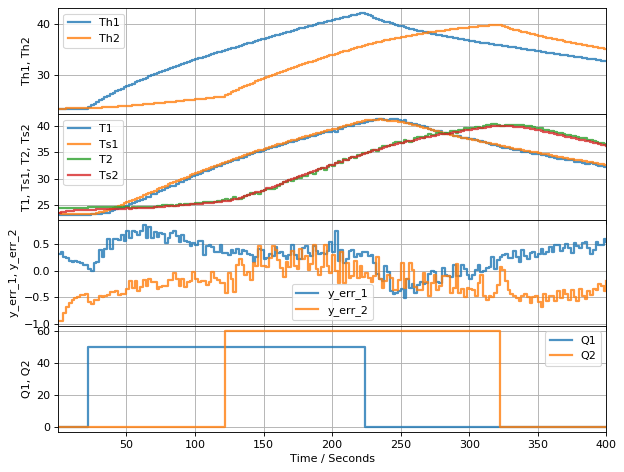

TCLab disconnected successfully.


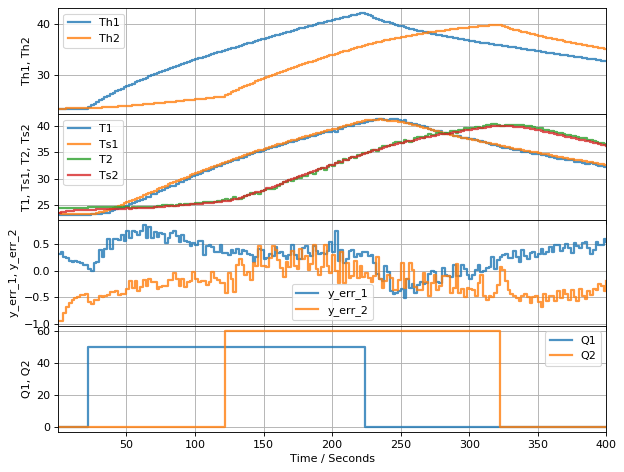

In [44]:
# placed multiple 2
observer = tclab_observer(L2, x_initial, d_initial)
with TCLab() as lab:

    # setup historian
    sources = [('T1', lambda: y[0]), 
               ('T2', lambda: y[1]), 
               ('Q1', lambda: u[0]), 
               ('Q2', lambda: u[1]),
               ('Th1', lambda: x[0]), 
               ('Ts1', lambda: x[1]), 
               ('Th2', lambda: x[2]), 
               ('Ts2', lambda: x[3]),
               ('y_err_1', lambda: y_err[0]),
               ('y_err_2', lambda: y_err[1]),
    ]
    h = Historian(sources)

    layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['Q1', 'Q2']]
    p = Plotter(h, t_final, layout)

    # initialize event loop
    next(observer)
    u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

    for t in clock(t_final, t_step):
        # get new measurement
        y = [lab.T1, lab.T2]
        x, y_err = observer.send([t, u, y])

        # update plotter and historian
        p.update(t)

        # set input for next period
        u = [lab.Q1(u1(t)), lab.Q2(u2(t))]

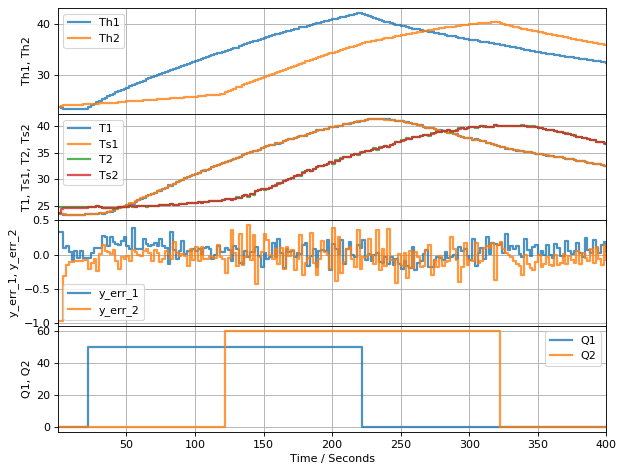

TCLab disconnected successfully.


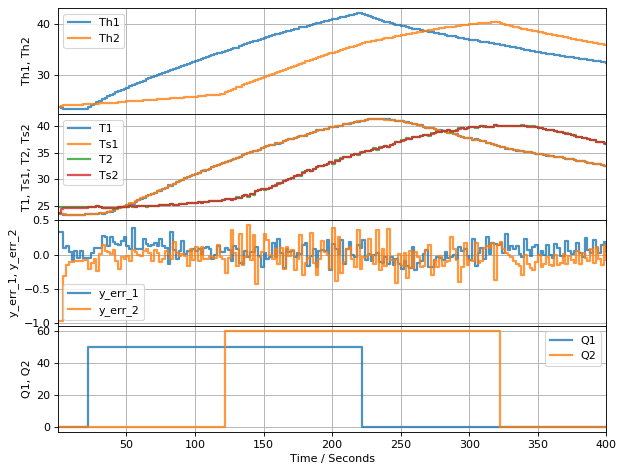

In [51]:
# placed multiple 5
observer = tclab_observer(L5, x_initial, d_initial)
with TCLab() as lab:

    # setup historian
    sources = [('T1', lambda: y[0]), 
               ('T2', lambda: y[1]), 
               ('Q1', lambda: u[0]), 
               ('Q2', lambda: u[1]),
               ('Th1', lambda: x[0]), 
               ('Ts1', lambda: x[1]), 
               ('Th2', lambda: x[2]), 
               ('Ts2', lambda: x[3]),
               ('y_err_1', lambda: y_err[0]),
               ('y_err_2', lambda: y_err[1]),
    ]
    h = Historian(sources)

    layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['Q1', 'Q2']]
    p = Plotter(h, t_final, layout)

    # initialize event loop
    next(observer)
    u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

    for t in clock(t_final, t_step):
        # get new measurement
        y = [lab.T1, lab.T2]
        x, y_err = observer.send([t, u, y])

        # update plotter and historian
        p.update(t)

        # set input for next period
        u = [lab.Q1(u1(t)), lab.Q2(u2(t))]

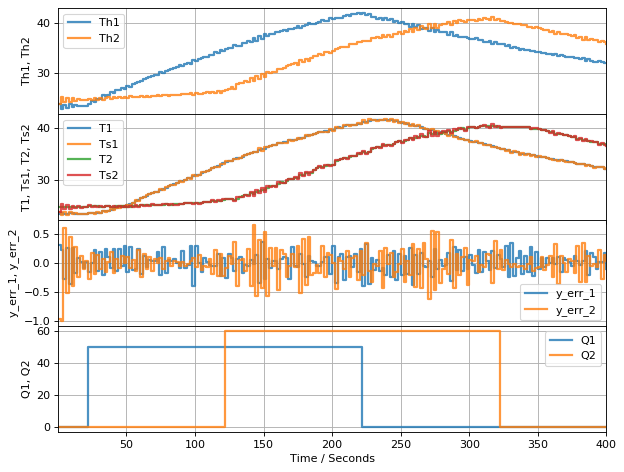

TCLab disconnected successfully.


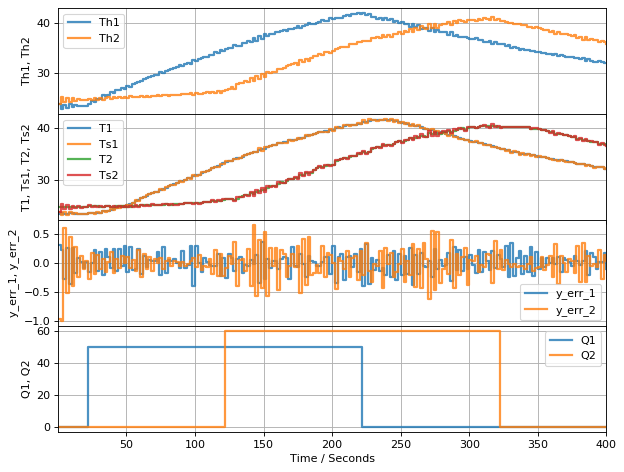

In [65]:
# placed multiple 10
observer = tclab_observer(L10, x_initial, d_initial)
with TCLab() as lab:

    # setup historian
    sources = [('T1', lambda: y[0]), 
               ('T2', lambda: y[1]), 
               ('Q1', lambda: u[0]), 
               ('Q2', lambda: u[1]),
               ('Th1', lambda: x[0]), 
               ('Ts1', lambda: x[1]), 
               ('Th2', lambda: x[2]), 
               ('Ts2', lambda: x[3]),
               ('y_err_1', lambda: y_err[0]),
               ('y_err_2', lambda: y_err[1]),
    ]
    h = Historian(sources)

    layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['Q1', 'Q2']]
    p = Plotter(h, t_final, layout)

    # initialize event loop
    next(observer)
    u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

    for t in clock(t_final, t_step):
        # get new measurement
        y = [lab.T1, lab.T2]
        x, y_err = observer.send([t, u, y])

        # update plotter and historian
        p.update(t)

        # set input for next period
        u = [lab.Q1(u1(t)), lab.Q2(u2(t))]

Of these 5 choices, I would take the 5x multiple, since the 1x multiple did not completely converge and the 10x multiple was almost too sensitive (with over-oscillation).  The 2x multiple was good as well, but the performance, both in convergence time and in precision, was better for the 5x multiple.

Question 2

In [66]:
A_aug = np.vstack([np.hstack([A, Bd]), np.zeros([1, 5])])
Bu_aug = np.vstack([Bu, [[0, 0]]])
Bd_aug = np.vstack([np.zeros([4, 1]), [[1]]])
C_aug = np.hstack([C, np.zeros([2, 1])])

print(A_aug)
print(Bu_aug)
print(Bd_aug)
print(C_aug)

[[-0.01835597  0.00963361  0.00415199  0.          0.00457037]
 [ 0.07372634 -0.07372634  0.          0.          0.        ]
 [ 0.00415199  0.         -0.01835597  0.00963361  0.00457037]
 [ 0.          0.          0.07372634 -0.07372634  0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[0.00373386 0.        ]
 [0.         0.        ]
 [0.         0.00186693]
 [0.         0.        ]
 [0.         0.        ]]
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [76]:
evals, _ = np.linalg.eig(A)
print(evals)
tau_new = 80
eigen_new = -1/tau_new
evals_new = np.hstack([5*evals,eigen_new])
print(evals_new)
results = place_poles(A_aug.T, C_aug.T, evals_new)
L_aug = results.gain_matrix.T
print(L_aug)

[-0.00401546 -0.01115662 -0.08507769 -0.08391486]
[-0.0200773  -0.05578309 -0.42538844 -0.4195743  -0.0125    ]
[[0.15837759 0.16223072]
 [0.37448823 0.03119081]
 [0.16192582 0.1588648 ]
 [0.03113217 0.37467027]
 [0.43951179 0.44077415]]


In [77]:
def tclab_observer_disturbance(L_aug, x_initial, d_hat):
    
    # initialize
    x_hat = np.hstack([x_initial, d_hat])
    print(x_hat)
    t = 0
    y_err = None

    while True:
        # save previous time value
        t_prev = t
        
        # yield current state and measurement error.
        # wait for message with next time, last control input, and measurement
        t, u, y = yield x_hat, y_err
        
        # model prediction
        x_pred = x_hat + (t - t_prev)*(np.dot(A_aug, x_hat) + np.dot(Bu_aug, u))
        y_pred = np.dot(C_aug, x_pred)
        
        # measurement correction
        y_err = y_pred - y
        x_hat = x_pred - (t - t_prev)*np.dot(L_aug, y_err)

In [78]:
# open connection to tclab
with TCLab() as lab:

    # setup historian
    sources = [('T1', lambda: y[0]), 
               ('T2', lambda: y[1]), 
               ('Q1', lambda: u[0]), 
               ('Q2', lambda: u[1]),
               ('Th1', lambda: x[0]), 
               ('Ts1', lambda: x[1]), 
               ('Th2', lambda: x[2]), 
               ('Ts2', lambda: x[3]),
               ('d_hat', lambda: x[4]),
               ('y_err_1', lambda: y_err[0]),
               ('y_err_2', lambda: y_err[1]),
    ]
    h = Historian(sources)

    layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['d_hat'], ['Q1', 'Q2']]
    p = Plotter(h, t_final, layout)

    # initialize event loop
    next(observer)
    u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

    for t in clock(t_final, t_step):
        # get new measurement
        y = [lab.T1 + d(t), lab.T2 + d(t)]
        # Note: if I were not using an artifical disturbance, y would only be composed of lab.T1 and lab.T2
        # This would be sufficient since lab.T1 and lab.T2 are the sensor temperatures
        x, y_err = observer.send([t, u, y])

        # update plotter and historian
        p.update(t)

        # set input for next period
        u = [lab.Q1(u1(t)), lab.Q2(u2(t))]

In [95]:
# I utilized an artifical disturbance, but with greater magnitude than in the example
# I also added a time dependence and on-off
# I don't have any way to create a real disturbance with a hair dryer or vacuum (my vacuum is broken)
def d(t):
    if t <= 200:
        return 0
    elif t > 200 and t <= 350:
        d = 8 + 8*(t-200)/150
        return d
    elif t > 350 and t <= 500:
        d = 16 - 8*(t-350)/150
        return d
    elif t > 500:
        return 0

In [96]:
def u1(t):
    return 50 if 20 <= t <= 320 else 0

def u2(t):
    return 60 if 120 <= t <= 420 else 0

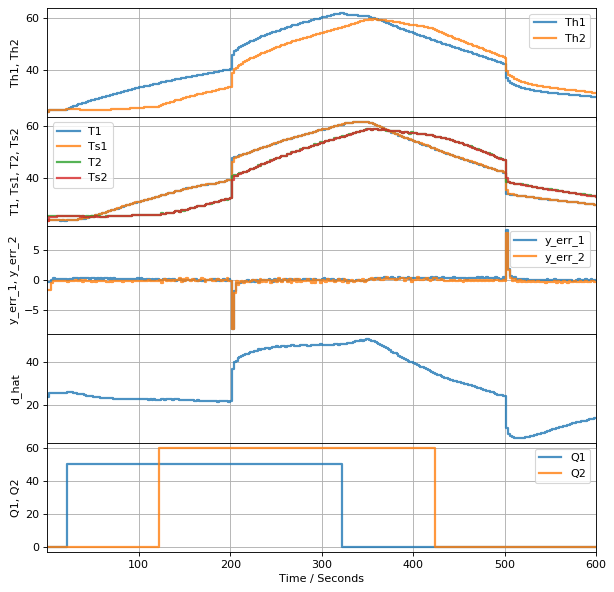

TCLab disconnected successfully.


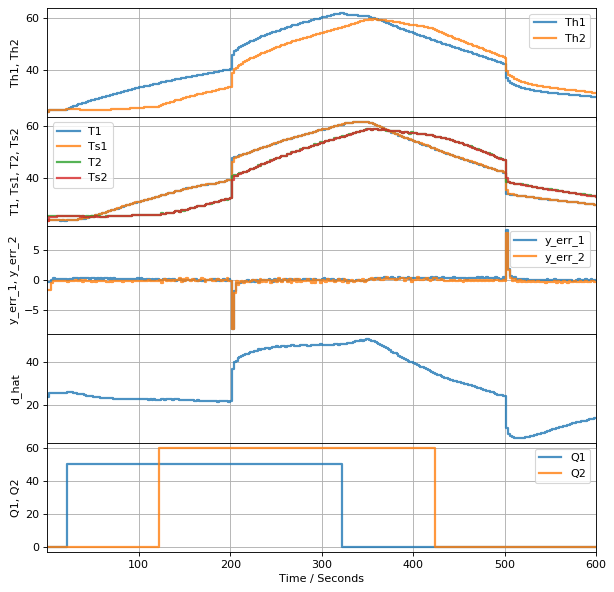

In [97]:
t_final = 600
t_step = 2
observer = tclab_observer_disturbance(L_aug, x_initial, d_initial)
experiment_disturbance(observer, u1, u2, t_final=600)

The estimator was very prompt in recognizing the disturbance, resolving the y error value in a few seconds.  Additionally, and importantly, the predicted sensor temperature was able to keep up with the returned value regardless of the step jumps (simulating sudden disturbances) and the functional change (simulating gradual increase and decrease in ambient temperature, or some increasing/decreasing disturbance that changes slightly with time.  This tells me the disturbance estimator, as well as the chosen values composing L (from the placement and the time constant I used, 80 seconds) worked very well to deal with error and adjust for the changes in (simulated) conditions.